In [1]:
import os
import pickle

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
series_names = [
      'acc1x',
      'acc1y',
      'acc1z',
      'acc2x',
      'acc2y',
      'acc2z',
      'gyrox',
      'gyroy',
      'gyroz',
      'magnx',
      'magny',
      'magnz',
      'force',
  ]

# EDA for Mixed

In [132]:
path_to_data = os.path.normpath('onhw2_both_indep_0/')
X_train = np.load(os.path.join(path_to_data, 'X_train.npy'),allow_pickle=True)
y_train = np.load(os.path.join(path_to_data, 'y_train.npy'),allow_pickle=True)
X_test = np.load(os.path.join(path_to_data, 'X_test.npy'),allow_pickle=True)
y_test = np.load(os.path.join(path_to_data, 'y_test.npy'),allow_pickle=True)

In [ ]:
X_train.shape[0], X_test.shape[0]

(23319, 7956)

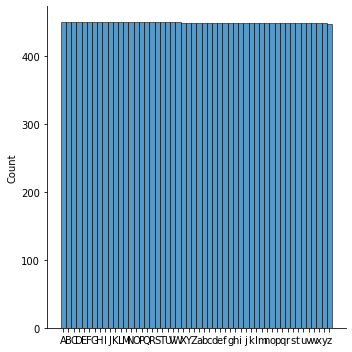

In [ ]:
sns.displot(y_train)

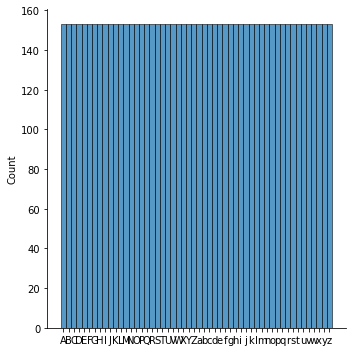

In [ ]:
sns.displot(y_test)

In [ ]:
entity_id = 0

In [734]:
def plot_series(entity_id, add_idx = None):
  fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(12,7))
  fig.suptitle(y_train[entity_id] + '_' + str(add_idx if add_idx is not None else ''), fontsize=24)
  axes[0][0].plot(X_train[entity_id][:,0], label='acc1x')
  axes[0][0].plot(X_train[entity_id][:,1], label='acc1y')
  axes[0][0].plot(X_train[entity_id][:,2], label='acc1z')
  axes[0][0].plot(X_train[entity_id][:,3], label='acc2x')
  axes[0][0].plot(X_train[entity_id][:,4], label='acc2y')
  axes[0][0].plot(X_train[entity_id][:,5], label='acc2z')
  axes[0][0].legend()

  axes[0][1].plot(X_train[entity_id][:,6], label='gyrox')
  axes[0][1].plot(X_train[entity_id][:,7], label='gyroy')
  axes[0][1].plot(X_train[entity_id][:,8], label='gyroz')
  axes[0][1].legend()

  axes[1][0].plot(X_train[entity_id][:,9], label='magnx')
  axes[1][0].plot(X_train[entity_id][:,10], label='magny')
  axes[1][0].plot(X_train[entity_id][:,11], label='magnz')
  axes[1][0].legend()

  axes[1][1].plot(X_train[entity_id][:,12], label='force')
  axes[1][1].legend()

  return fig

In [735]:
letters = list(filter( lambda x: x.isalpha(), [chr(x) for x in range(ord('A'), ord('z'))]))

In [ ]:
letters_sel = ['A', 'C', 'M', 'O', 'R', 'a', 'c', 'm', 'o', 'r']

In [741]:
from collections import defaultdict

selected_samples = defaultdict(list)
for char in letters: 
  selected_samples[char] = np.argwhere(y_train == char).squeeze()
  

KeyboardInterrupt: ignored

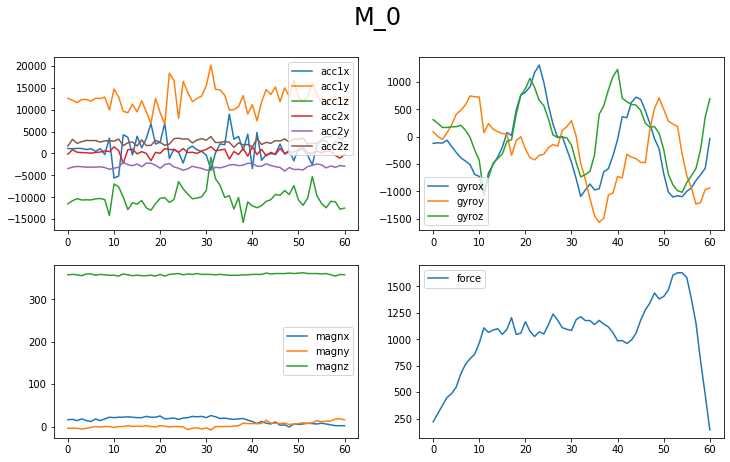

In [ ]:
output_dir = '/content/drive/MyDrive/otus_project/graphs'

for char in letters_sel:
  for idx, sample_idx in enumerate(selected_samples[char][:10]):
    postfix = None
    if char.islower():
      postfix = '_lower'
    else:
      postfix = ''
    fig = plot_series(sample_idx, idx)
    os.makedirs(os.path.join(output_dir, char + postfix), exist_ok=True)
    fig.savefig(os.path.join(output_dir, char + postfix, f'{char + postfix}_{idx}.png'))
    plt.close()

In [742]:
stat_cols = {'letter': [], 
             'ts_len': []}

#stats = pd.DataFrame(columns =stat_cols )

for char in letters:
  for sample_idx in selected_samples[char]:
    stat_cols['ts_len'].append(X_train[sample_idx].shape[0])
    stat_cols['letter'].append(char)

stats = pd.DataFrame.from_dict(stat_cols)

In [743]:
stats['ts_len'].mean()

49.17676635187129

In [744]:
max_seq_len = 60

<AxesSubplot:xlabel='letter', ylabel='ts_len'>

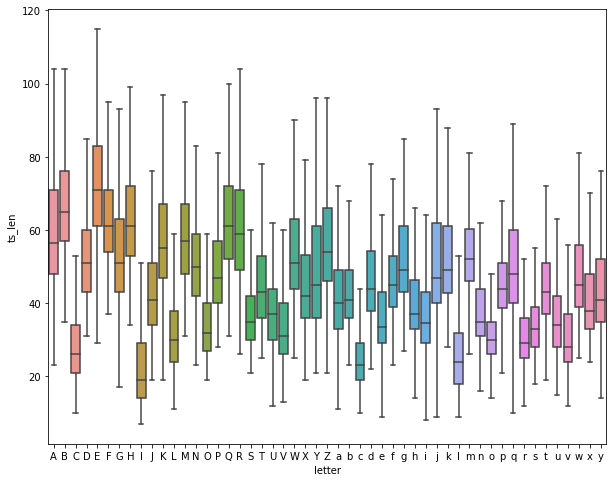

In [745]:
fig = plt.figure(figsize=(10, 8))
sns.boxplot(x='letter', y='ts_len', data=stats, showfliers=False)

<AxesSubplot:xlabel='letter', ylabel='ts_len'>

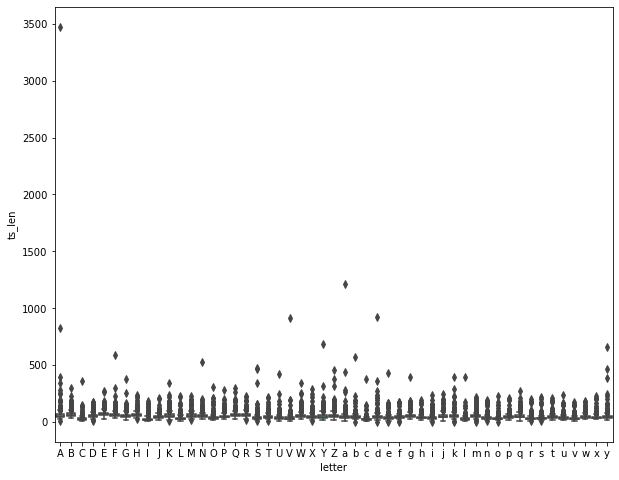

In [746]:
fig = plt.figure(figsize=(10, 8))
sns.boxplot(x='letter', y='ts_len', data=stats, showfliers=True)

* Фильтрация слишком длинных и слишком коротких последовательностей? + Интерполяция
* Базовая модель?
* Параметры для tsfresh?



# Resampler

In [5]:
from scipy.signal import resample

def get_resampled_data(X, y, target_len=60):
  data_resampled = dict(zip(series_names, [list() for x in range(0, len(series_names))]))
  new_y = []
  for item_idx, item in enumerate(X):
    #print(item_idx)
    if item.shape[0] == 0:
      continue
    for series_idx, series in enumerate(series_names):
      data_resampled[series].append(resample(item[:, series_idx], target_len))
    new_y.append(y[item_idx])
  stacked_data = {}
  for key, value in data_resampled.items():
    stacked_data[key] = np.stack(value, axis=0)
  return stacked_data, np.array(new_y)

def make_pd(X):
  new_X = np.concatenate(list(X.values()), axis=1)
  return new_X

# Baseline
## Mixed

In [133]:
X_train_resampled, y_train_resampled = get_resampled_data(X_train, y_train)
X_test_resampled, y_test_resampled = get_resampled_data(X_test, y_test)

In [134]:
X_train_concated = make_pd(X_train_resampled)
X_test_concated = make_pd(X_test_resampled)

### LogisticRegression

In [147]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [148]:
pipeline_basic = Pipeline([('scaler', StandardScaler()), 
                     ('model',LogisticRegression(max_iter=10000))])

In [149]:
pipeline_basic.fit(X_train_concated, y_train_resampled)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(max_iter=10000))])

In [150]:
pipeline_basic.score(X_test_concated, y_test_resampled)

0.3963046757164404

In [151]:
test_pred = pipeline_basic.predict(X_test_concated)

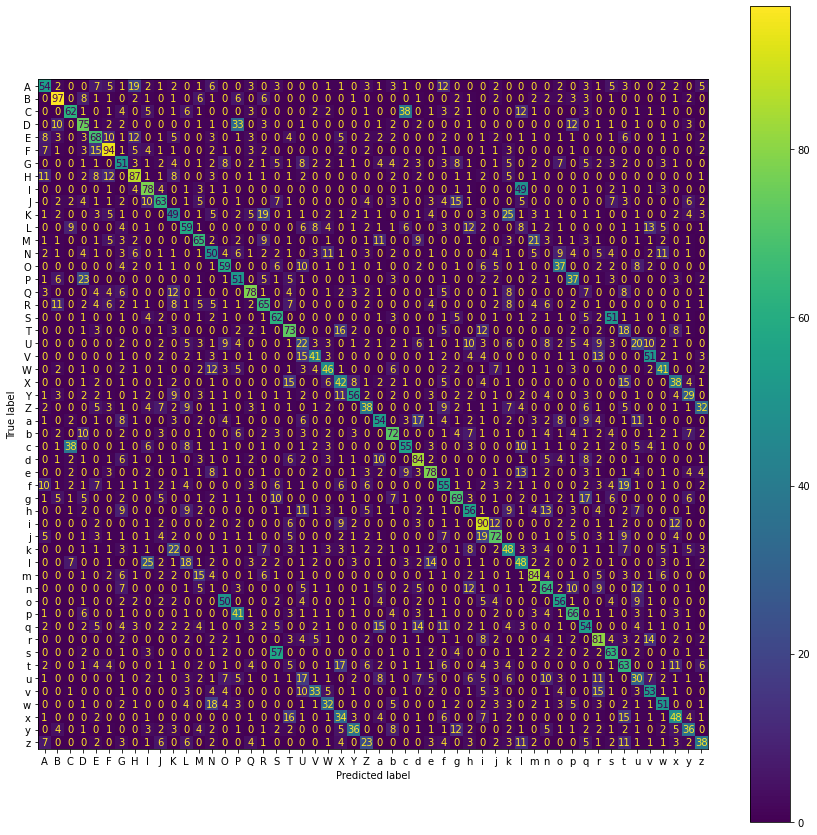

In [152]:
fig, ax = plt.subplots(figsize=(15,15))
ConfusionMatrixDisplay.from_predictions(y_test_resampled, test_pred, ax=ax)
plt.show()

### SVM

In [700]:
from sklearn.svm import LinearSVC

In [706]:
pipeline_svm = Pipeline([('scaler', StandardScaler()), 
                     ('model',LinearSVC(max_iter=10000))])

In [707]:
pipeline_svm.fit(X_train_concated, y_train_resampled)

/home/abegaev/miniconda3/envs/stabillo-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LinearSVC(max_iter=10000))])

In [708]:
pipeline_svm.score(X_test_concated, y_test_resampled)

0.3866264454499749

In [709]:
test_pred = pipeline_svm.predict(X_test_concated)

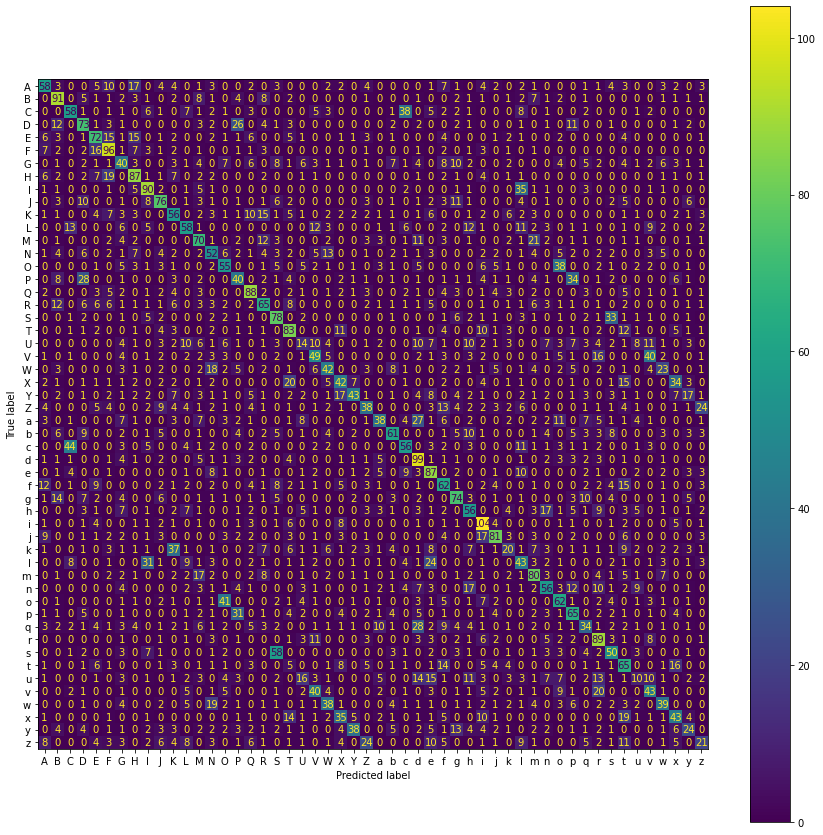

In [710]:
fig, ax = plt.subplots(figsize=(15,15))
ConfusionMatrixDisplay.from_predictions(y_test_resampled, test_pred, ax=ax)
plt.show()

### XGBoost

In [135]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier

In [448]:
xgb_pipeline_mixed =Pipeline([('scaler', StandardScaler()), 
                     ('model', XGBClassifier(n_estimators=500,max_depth=10,learning_rate=0.1))])

In [449]:
xgb_pipeline_mixed.fit(X_train_concated, y_train_resampled)

/home/abegaev/miniconda3/envs/stabillo-env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:22:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=500,
                               n_jobs=64, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=None, subsample=1,
                               tree_method='exact', validate_parameters=1,
    

In [450]:
xgb_pipeline_mixed.score(X_test_concated, y_test_resampled)

0.5780542986425339

In [209]:
test_pred = xgb_pipeline.predict(X_test_concated)

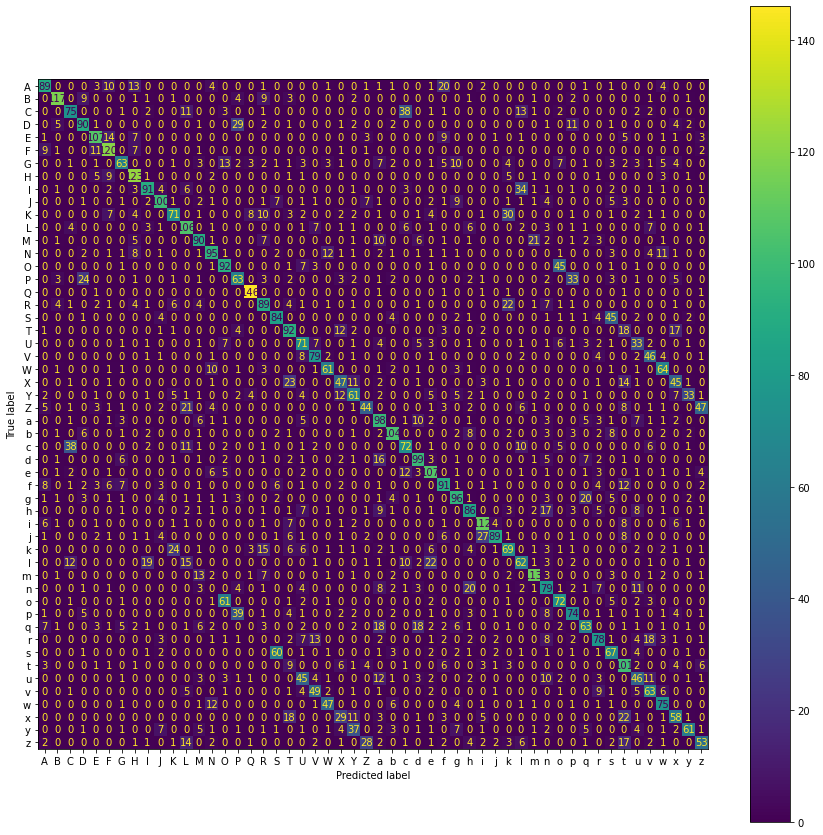

In [210]:
fig, ax = plt.subplots(figsize=(15,15))
ConfusionMatrixDisplay.from_predictions(y_test_resampled, test_pred, ax=ax)
plt.show()

### LightGBM

In [664]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from lightgbm import LGBMClassifier

In [665]:
lgbm_pipeline_mixed =Pipeline([('scaler', StandardScaler()), 
                     ('model', LGBMClassifier(n_estimators=500,max_depth=10,learning_rate=0.1))])

In [666]:
lgbm_pipeline_mixed.fit(X_train_concated, y_train_resampled)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LGBMClassifier(max_depth=10, n_estimators=500))])

In [667]:
lgbm_pipeline_mixed.score(X_test_concated, y_test_resampled)

0.5746606334841629

In [668]:
test_pred = lgbm_pipeline_mixed.predict(X_test_concated)

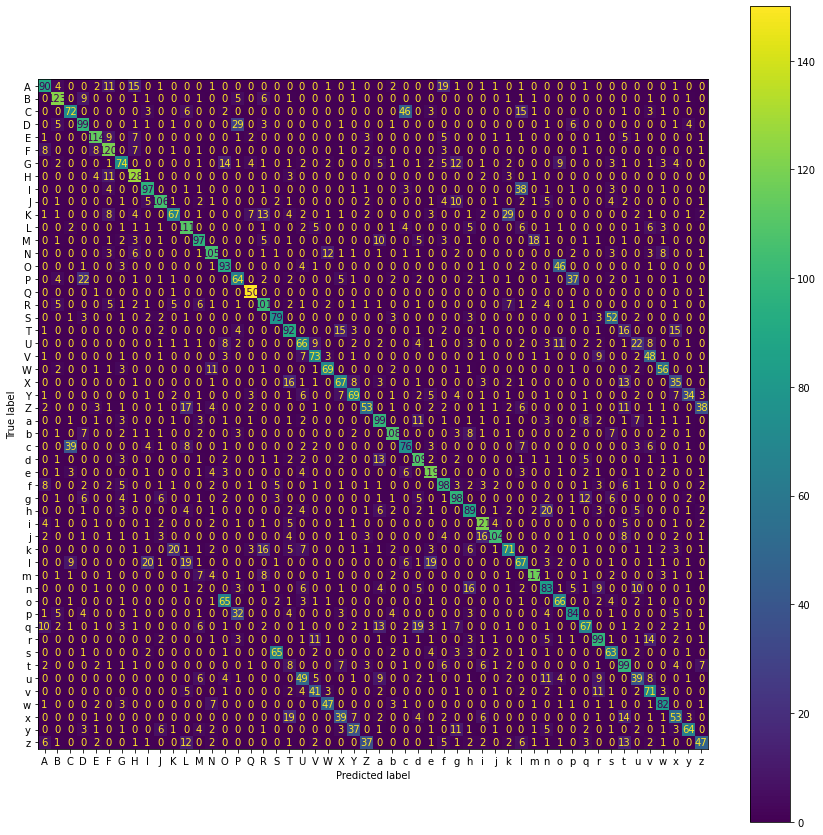

In [669]:
fig, ax = plt.subplots(figsize=(15,15))
ConfusionMatrixDisplay.from_predictions(y_test_resampled, test_pred, ax=ax)
plt.show()

### Bayesian

In [237]:
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import accuracy_score

In [238]:
import pymc3 as pm
import theano
import theano.tensor as T
floatX = theano.config.floatX

In [239]:
le = LabelEncoder()
y_train_resampled_t = le.fit_transform(y_train_resampled)

In [240]:
y_train_resampled_t.shape

(23316,)

In [241]:
print(np.unique(y_train_resampled_t).shape)

(52,)


In [242]:
scaled = StandardScaler()

In [243]:
X_scaled =  scaled.fit_transform(X_train_concated)

$w_1 \sim N(0, 1);  
w_2 \sim N(0, 1); 
p(\hat{y}) \sim P(softmax(w_1x + w_2))$

In [244]:
model = pm.Model()
#n_hidden = 16
init_1 = np.random.rand(X_scaled.shape[1], 52).astype(floatX)
init_2= np.random.rand(1).astype(floatX)
with model:
  ann_input = pm.Data("ann_input", X_scaled)
  ann_output = pm.Data("ann_output", y_train_resampled_t)
  weights_in_1 = pm.Normal("w", 0, sigma=1, shape=(X_scaled.shape[1], 52), testval=init_1)
  weights_b = pm.Normal("bias", 0, sigma=1, shape=(1, 52), testval=init_2)

  p = pm.math.dot(ann_input, weights_in_1) + weights_b


  #sigma = pm.HalfNormal('sigma', sd=1, shape=(X_train_concated.shape[0], 52))

  printing_op = theano.printing.Print('vector', attrs=['shape'])
  printed_x = printing_op(p)
  printed_x = printing_op(pm.math.exp(p))
  printed_x = printing_op(ann_output)
  #latent = pm.Normal('latent', mu=mu, sd=sigma, shape=X_train_concated.shape[0])

  
  p1 = pm.Deterministic('p', p.exp()/p.exp().sum())
  #probs = pm.math.exp(p) / pm.math.sum(pm.math.exp(p), 0, keepdims=True)

  printed_x = printing_op(p1)
  Y_obs = pm.Categorical('y_obs', p=p1, observed=y_train_resampled_t)

vector shape = (23316, 52)
vector shape = (23316, 52)
vector shape = (23316,)
vector shape = (23316, 52)


In [245]:
with model:
  inference = pm.ADVI()
  approx = pm.fit(n=10000, method=inference)

Interrupted at 41 [0%]: Average Loss = 1.0408e+06


In [ ]:
X_test_scaled = scaled.transform(X_test_concated)

In [ ]:
# create symbolic input
x = T.matrix("X")
# symbolic number of samples is supported, we build vectorized posterior on the fly
n = T.iscalar("n")
# Do not forget test_values or set theano.config.compute_test_value = 'off'
x.tag.test_value = np.empty_like(X_scaled[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(
    model.y_obs.distribution.p, size=n, more_replacements={model["ann_input"]: x}
)

sample_proba = theano.function([x, n], _sample_proba)

pred = sample_proba(X_test_scaled, 500).mean(0)



In [ ]:
np.argmax(pred, axis=-1).shape

In [ ]:
y_test_resampled_t = le.fit_transform(y_test_resampled)
accuracy_score(y_test_resampled_t,np.argmax(pred, axis=-1))

0.41603821015585724

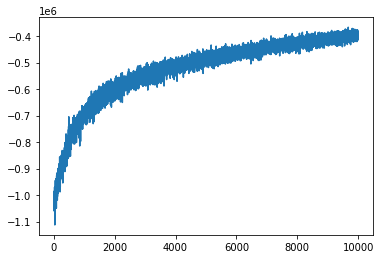

In [ ]:
plt.plot(-inference.hist)

## Small Case

In [585]:
path_to_data = os.path.normpath('onhw2_lower_indep_0/')
X_train_small = np.load(os.path.join(path_to_data, 'X_train.npy'),allow_pickle=True)
y_train_small = np.load(os.path.join(path_to_data, 'y_train.npy'),allow_pickle=True)
X_test_small = np.load(os.path.join(path_to_data, 'X_test.npy'),allow_pickle=True)
y_test_small = np.load(os.path.join(path_to_data, 'y_test.npy'),allow_pickle=True)

In [586]:
X_train_small_resampled, y_train_small_resampled = get_resampled_data(X_train_small, y_train_small)
X_test_small_resampled, y_test_small_resampled = get_resampled_data(X_test_small, y_test_small)
X_train_small_concated = make_pd(X_train_small_resampled)
X_test_small_concated = make_pd(X_test_small_resampled)

### LogisticRegression

In [587]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [588]:
pipeline_sm_basic = Pipeline([('scaler', StandardScaler()), 
                     ('model',LogisticRegression(max_iter=10000))])
pipeline_sm_basic.fit(X_train_small_concated, y_train_small_resampled)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(max_iter=10000))])

In [589]:
pipeline_sm_basic.score(X_test_small_concated, y_test_small_resampled)

0.5065359477124183

In [590]:
test_pred = pipeline_sm_basic.predict(X_test_small_concated)

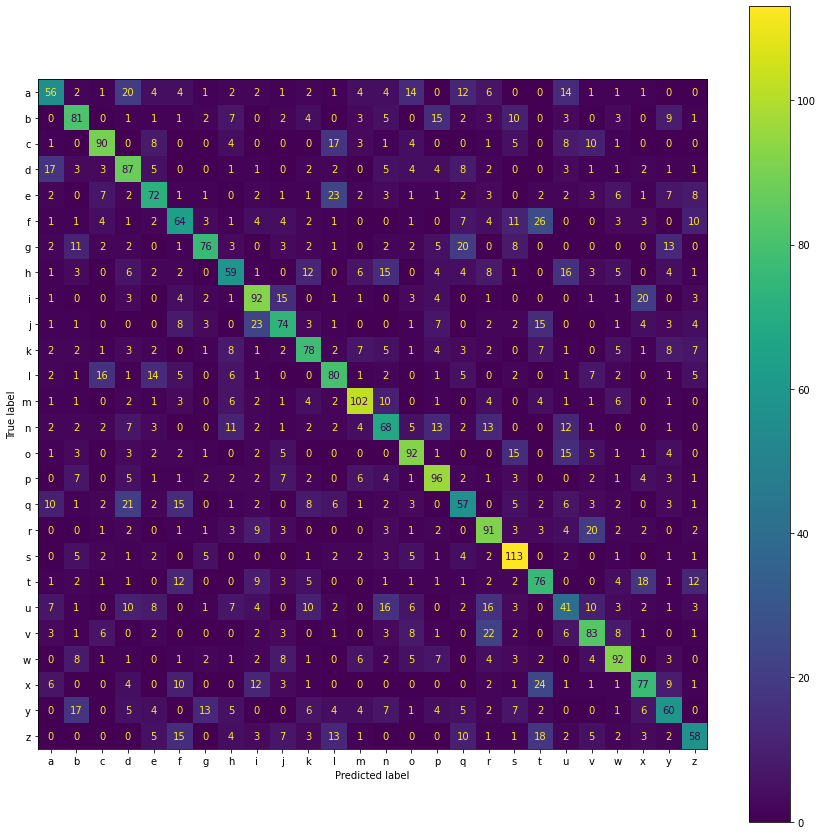

In [591]:
fig, ax = plt.subplots(figsize=(15,15))
ConfusionMatrixDisplay.from_predictions(y_test_small_resampled, test_pred, ax=ax)
plt.show()

### SVM

In [717]:
from sklearn.svm import LinearSVC

In [718]:
pipeline_svm = Pipeline([('scaler', StandardScaler()), 
                     ('model',LinearSVC(max_iter=10000))])

In [719]:
pipeline_svm.fit(X_train_small_concated, y_train_small_resampled)

/home/abegaev/miniconda3/envs/stabillo-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LinearSVC(max_iter=10000))])

In [720]:
pipeline_svm.score(X_test_small_concated, y_test_small_resampled)

0.4917043740573152

In [721]:
test_pred = pipeline_svm.predict(X_test_small_concated)

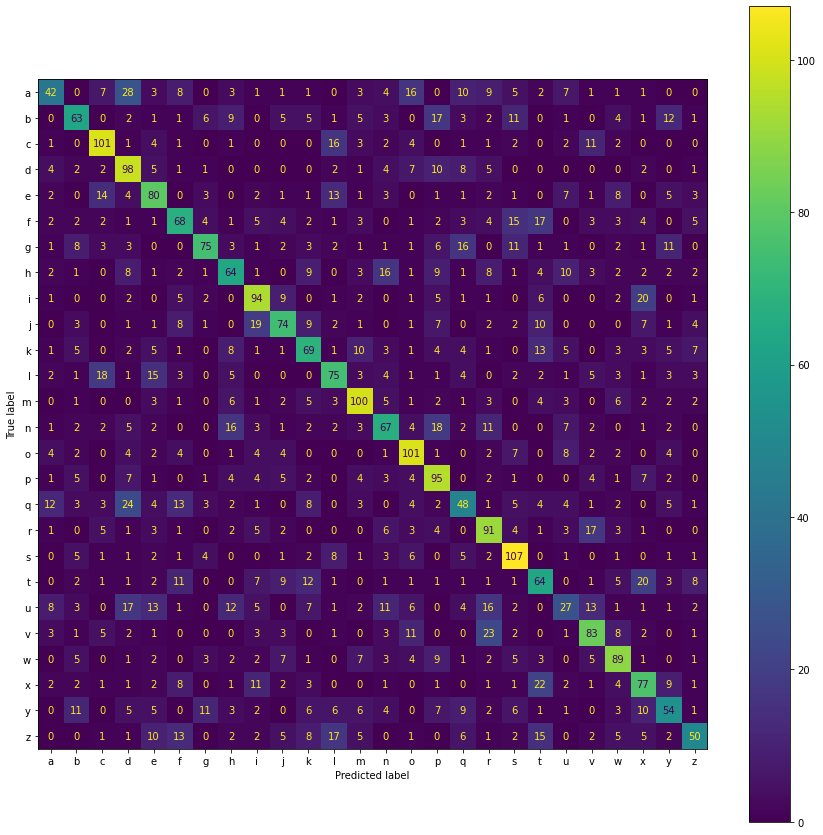

In [722]:
fig, ax = plt.subplots(figsize=(15,15))
ConfusionMatrixDisplay.from_predictions(y_test_small_resampled, test_pred, ax=ax)
plt.show()

### XGBoost

In [592]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier

In [593]:
xgb_sm_pipeline =Pipeline([('scaler', StandardScaler()), 
                        ('model', XGBClassifier(n_estimators=500,max_depth=10,learning_rate=0.1))])

In [594]:
xgb_sm_pipeline.fit(X_train_small_concated, y_train_small_resampled)

/home/abegaev/miniconda3/envs/stabillo-env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:46:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=500,
                               n_jobs=64, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=None, subsample=1,
                               tree_method='exact', validate_parameters=1,
    

In [595]:
xgb_sm_pipeline.score(X_test_small_concated, y_test_small_resampled)

0.7051282051282052

In [596]:
test_pred = xgb_sm_pipeline.predict(X_test_small_concated)

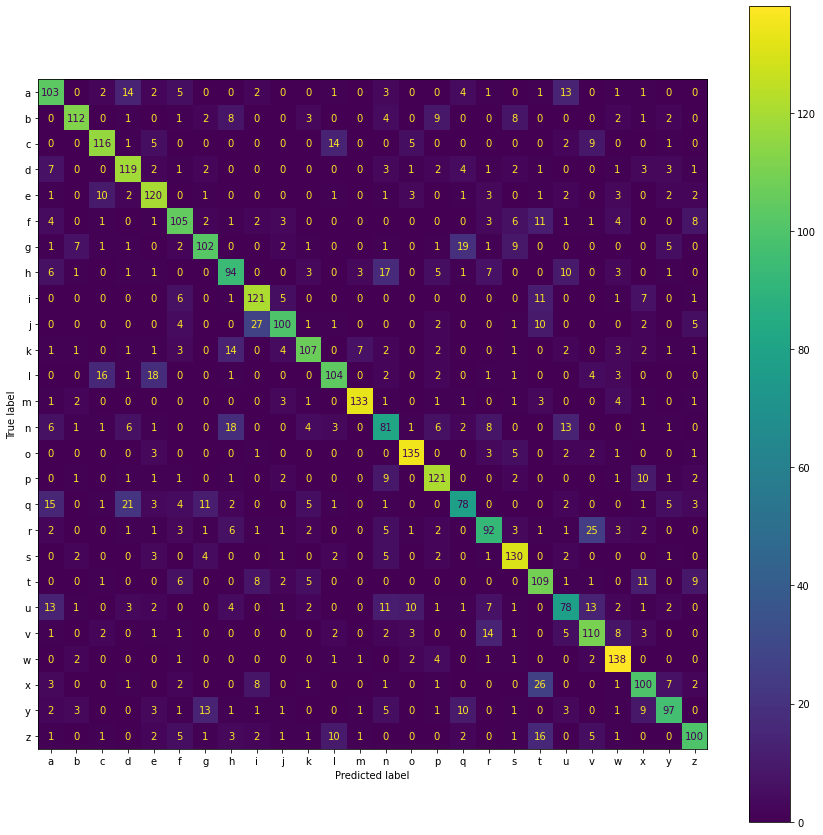

In [597]:
fig, ax = plt.subplots(figsize=(15,15))
ConfusionMatrixDisplay.from_predictions(y_test_small_resampled, test_pred, ax=ax)
plt.show()

### LightGBM

In [664]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from lightgbm import LGBMClassifier

In [689]:
lgbm_pipeline_sm =Pipeline([('scaler', StandardScaler()), 
                     ('model', LGBMClassifier(n_estimators=500,max_depth=10,learning_rate=0.1))])

In [690]:
lgbm_pipeline_sm.fit(X_train_small_concated, y_train_small_resampled)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LGBMClassifier(max_depth=10, n_estimators=500))])

In [691]:
lgbm_pipeline_sm.score(X_test_small_concated, y_test_small_resampled)

0.7194570135746606

In [692]:
test_pred = lgbm_pipeline_sm.predict(X_test_small_concated)

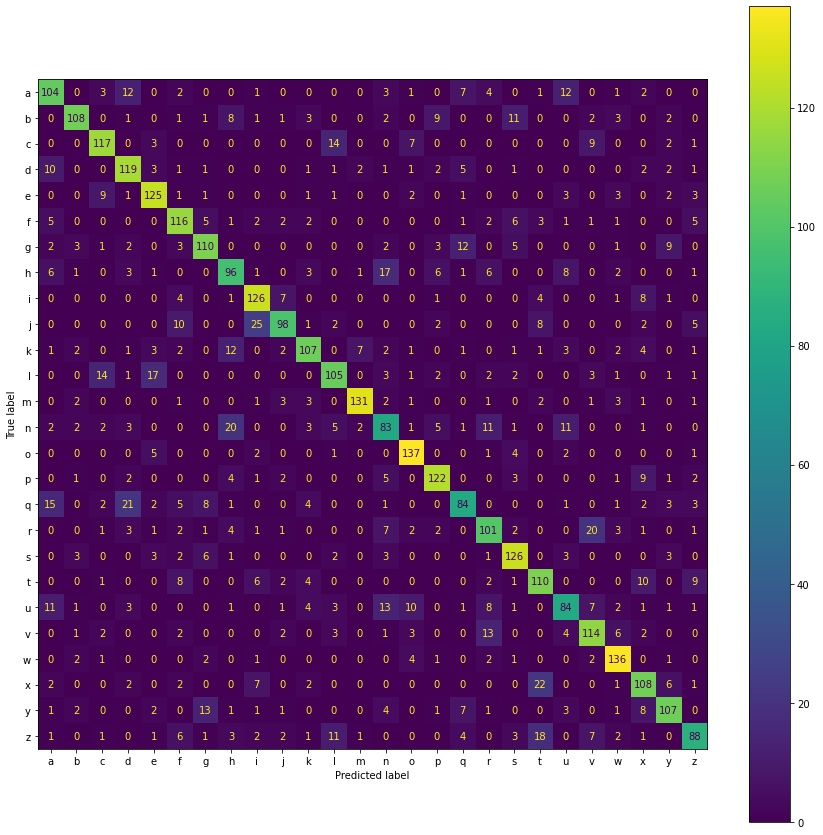

In [693]:
fig, ax = plt.subplots(figsize=(15,15))
ConfusionMatrixDisplay.from_predictions(y_test_small_resampled, test_pred, ax=ax)
plt.show()

### Bayesian

In [598]:
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import accuracy_score

In [599]:
import pymc3 as pm
import theano
import theano.tensor as T
floatX = theano.config.floatX

In [600]:
le = LabelEncoder()
y_train_small_resampled_t = le.fit_transform(y_train_small_resampled)

In [601]:
scaled = StandardScaler()
X_small_scaled =  scaled.fit_transform(X_train_small_concated)

In [602]:
model_sm = pm.Model()
#n_hidden = 16
init_1 = np.random.rand(X_small_scaled.shape[1], 52).astype(floatX)
init_2= np.random.rand(1).astype(floatX)
with model_sm:
  ann_input = pm.Data("ann_input", X_small_scaled)
  ann_output = pm.Data("ann_output", y_train_small_resampled_t)
  weights_in_1 = pm.Normal("w", 0, sigma=1, shape=(X_small_scaled.shape[1], 52), testval=init_1)
  weights_b = pm.Normal("bias", 0, sigma=1, shape=(1, 52), testval=init_2)

  p = pm.math.dot(ann_input, weights_in_1) + weights_b
  p1 = pm.Deterministic('p', p.exp()/p.exp().sum())

  Y_obs = pm.Categorical('y_obs', p=p1, observed=y_train_small_resampled_t)

In [603]:
with model_sm:
  inference = pm.ADVI()
  approx = pm.fit(n=10000, method=inference)

Finished [100%]: Average Loss = 1.7222e+05


In [604]:
X_test_small_scaled = scaled.transform(X_test_small_concated)

In [605]:
# create symbolic input
x = T.matrix("X")
# symbolic number of samples is supported, we build vectorized posterior on the fly
n = T.iscalar("n")
# Do not forget test_values or set theano.config.compute_test_value = 'off'
x.tag.test_value = np.empty_like(X_small_scaled[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(
    model_sm.y_obs.distribution.p, size=n, more_replacements={model_sm["ann_input"]: x}
)

sample_proba = theano.function([x, n], _sample_proba)

pred = sample_proba(X_test_small_scaled, 500).mean(0)



In [606]:
np.argmax(pred, axis=-1).shape

(3978,)

In [607]:
y_test_small_resampled_t = le.fit_transform(y_test_small_resampled)
accuracy_score(y_test_small_resampled_t, np.argmax(pred, axis=-1))

0.5407239819004525

## Large Case

In [608]:
path_to_data = os.path.normpath('onhw2_upper_indep_0/')
X_train_large = np.load(os.path.join(path_to_data, 'X_train.npy'),allow_pickle=True)
y_train_large = np.load(os.path.join(path_to_data, 'y_train.npy'),allow_pickle=True)
X_test_large = np.load(os.path.join(path_to_data, 'X_test.npy'),allow_pickle=True)
y_test_large = np.load(os.path.join(path_to_data, 'y_test.npy'),allow_pickle=True)

In [609]:
X_train_large_resampled, y_train_large_resampled = get_resampled_data(X_train_large, y_train_large)
X_test_large_resampled, y_test_large_resampled = get_resampled_data(X_test_large, y_test_large)
X_train_large_concated = make_pd(X_train_large_resampled)
X_test_large_concated = make_pd(X_test_large_resampled)

### LogisticRegression

In [610]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [611]:
pipeline_lg_basic = Pipeline([('scaler', StandardScaler()), 
                     ('model',LogisticRegression(max_iter=10000))])
pipeline_lg_basic.fit(X_train_large_concated, y_train_large_resampled)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(max_iter=10000))])

In [612]:
pipeline_lg_basic.score(X_test_large_concated, y_test_large_resampled)

0.5475113122171946

In [613]:
test_pred = pipeline_lg_basic.predict(X_test_large_concated)

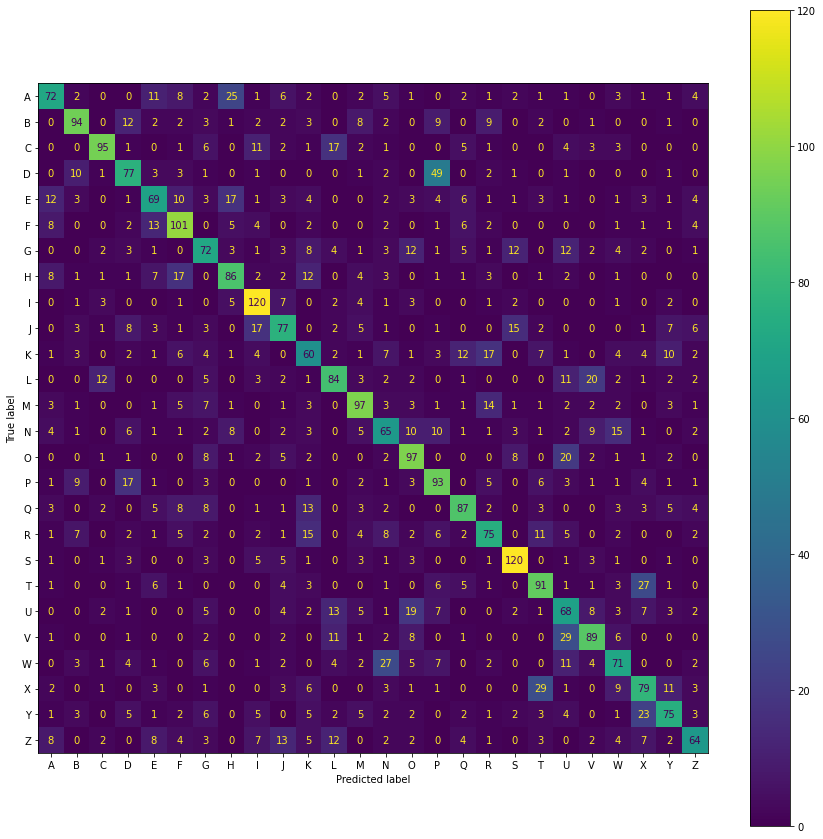

In [614]:
fig, ax = plt.subplots(figsize=(15,15))
ConfusionMatrixDisplay.from_predictions(y_test_large_resampled, test_pred, ax=ax)
plt.show()

### SVM

In [717]:
from sklearn.svm import LinearSVC

In [723]:
pipeline_svm = Pipeline([('scaler', StandardScaler()), 
                     ('model',LinearSVC(max_iter=10000))])

In [724]:
pipeline_svm.fit(X_train_large_concated, y_train_large_resampled)

/home/abegaev/miniconda3/envs/stabillo-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LinearSVC(max_iter=10000))])

In [725]:
pipeline_svm.score(X_test_large_concated, y_test_large_resampled)

0.5404725992961287

In [726]:
test_pred = pipeline_svm.predict(X_test_large_concated)

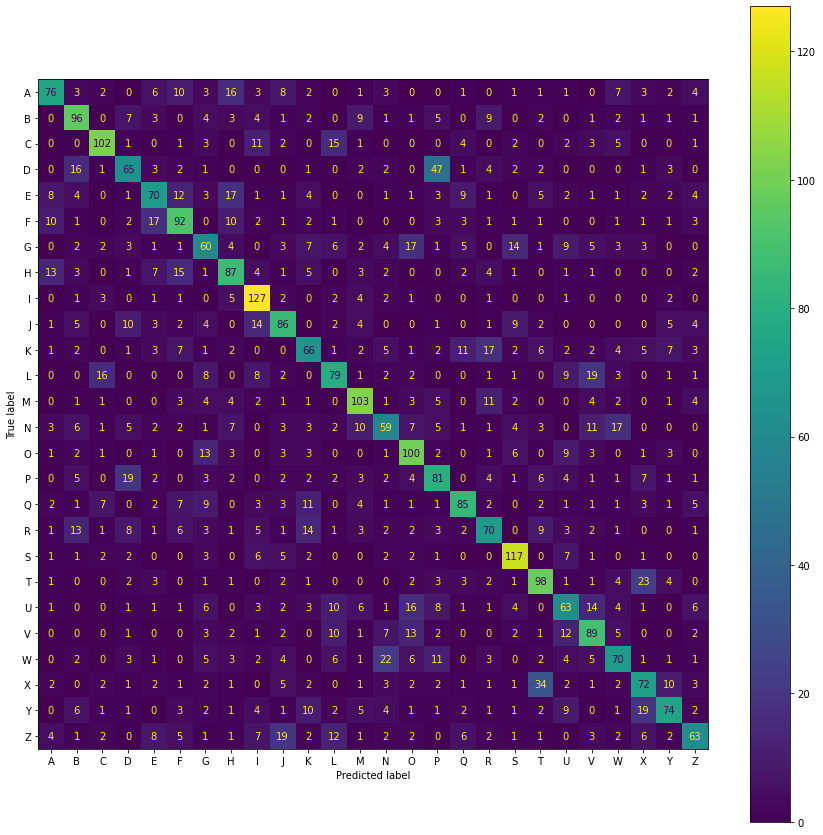

In [727]:
fig, ax = plt.subplots(figsize=(15,15))
ConfusionMatrixDisplay.from_predictions(y_test_large_resampled, test_pred, ax=ax)
plt.show()

### XGBoost

In [615]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier

In [616]:
xgb_lg_pipeline =Pipeline([('scaler', StandardScaler()), 
                        ('model', XGBClassifier(n_estimators=500,max_depth=10,learning_rate=0.1))])

In [617]:
xgb_lg_pipeline.fit(X_train_large_concated, y_train_large_resampled)

/home/abegaev/miniconda3/envs/stabillo-env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:00:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=500,
                               n_jobs=64, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=None, subsample=1,
                               tree_method='exact', validate_parameters=1,
    

In [618]:
xgb_lg_pipeline.score(X_test_large_concated, y_test_large_resampled)

0.756913021618904

In [619]:
test_pred = xgb_lg_pipeline.predict(X_test_large_concated)

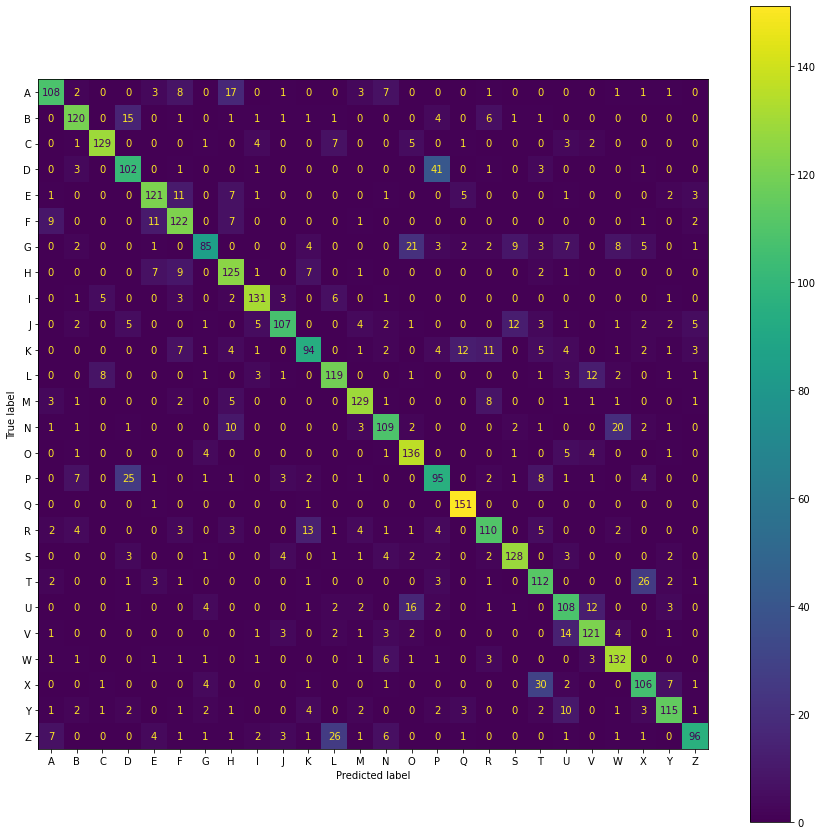

In [620]:
fig, ax = plt.subplots(figsize=(15,15))
ConfusionMatrixDisplay.from_predictions(y_test_large_resampled, test_pred, ax=ax)
plt.show()

### LightGBM

In [694]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from lightgbm import LGBMClassifier

In [695]:
lgbm_pipeline_lg =Pipeline([('scaler', StandardScaler()), 
                     ('model', LGBMClassifier(n_estimators=500,max_depth=10,learning_rate=0.1))])

In [696]:
lgbm_pipeline_lg.fit(X_train_large_concated, y_train_large_resampled)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LGBMClassifier(max_depth=10, n_estimators=500))])

In [697]:
lgbm_pipeline_lg.score(X_test_large_concated, y_test_large_resampled)

0.7727501256913022

In [698]:
test_pred = lgbm_pipeline_lg.predict(X_test_large_concated)

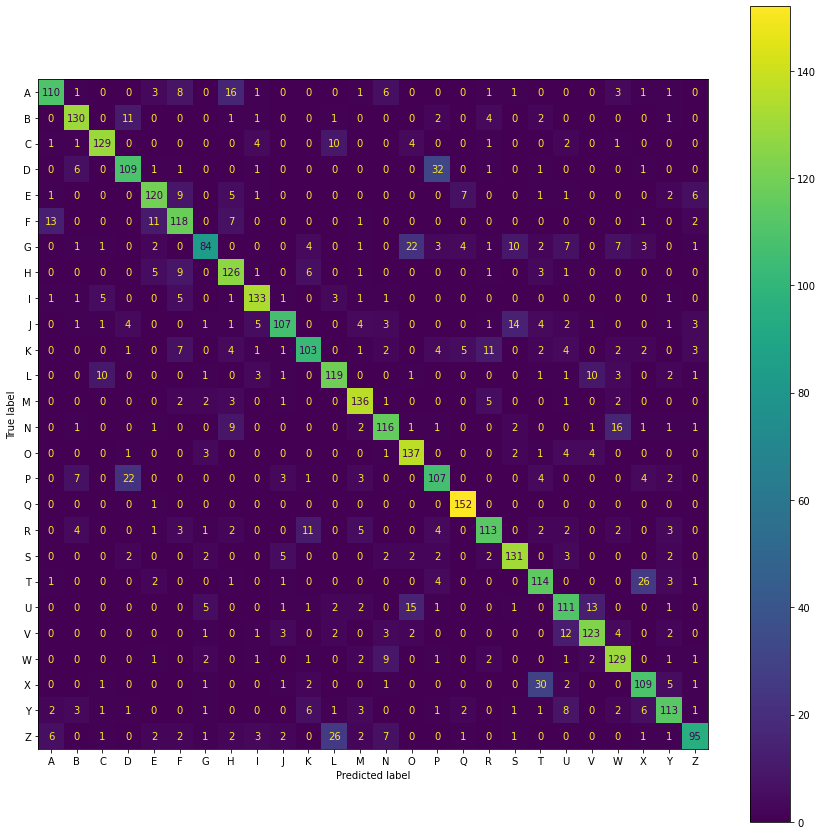

In [699]:
fig, ax = plt.subplots(figsize=(15,15))
ConfusionMatrixDisplay.from_predictions(y_test_large_resampled, test_pred, ax=ax)
plt.show()

### Bayesian

In [747]:
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import accuracy_score

In [748]:
import pymc3 as pm
import theano
import theano.tensor as T
floatX = theano.config.floatX

In [749]:
le = LabelEncoder()
y_train_large_resampled_t = le.fit_transform(y_train_large_resampled)

In [750]:
scaled = StandardScaler()
X_large_scaled =  scaled.fit_transform(X_train_large_concated)

In [751]:
model_lg= pm.Model()
#n_hidden = 16
init_1 = np.random.rand(X_large_scaled.shape[1], 52).astype(floatX)
init_2= np.random.rand(1).astype(floatX)
with model_lg:
  ann_input = pm.Data("ann_input", X_large_scaled)
  ann_output = pm.Data("ann_output", y_train_large_resampled_t)
  weights_in_1 = pm.Normal("w", 0, sigma=1, shape=(X_large_scaled.shape[1], 52), testval=init_1)
  weights_b = pm.Normal("bias", 0, sigma=1, shape=(1, 52), testval=init_2)

  p = pm.math.dot(ann_input, weights_in_1) + weights_b
  p1 = pm.Deterministic('p', p.exp()/p.exp().sum())

  Y_obs = pm.Categorical('y_obs', p=p1, observed=y_train_large_resampled_t)

In [752]:
with model_lg:
  inference = pm.ADVI()
  approx = pm.fit(n=8500, method=inference)

Finished [100%]: Average Loss = 1.5795e+05


In [753]:
X_test_large_scaled = scaled.transform(X_test_large_concated)

In [755]:
# create symbolic input
x = T.matrix("X")
# symbolic number of samples is supported, we build vectorized posterior on the fly
n = T.iscalar("n")
# Do not forget test_values or set theano.config.compute_test_value = 'off'
x.tag.test_value = np.empty_like(X_large_scaled[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(
    model_lg.y_obs.distribution.p, size=n, more_replacements={model_lg["ann_input"]: x}
)

sample_proba = theano.function([x, n], _sample_proba)

pred = sample_proba(X_test_large_scaled, 500).mean(0)



In [756]:
np.argmax(pred, axis=-1).shape

(3978,)

In [757]:
y_test_large_resampled_t = le.fit_transform(y_test_large_resampled)
accuracy_score(y_test_large_resampled_t, np.argmax(pred, axis=-1))

0.6138763197586727

# Feature Engineering
В качестве базового алгоритма выберем XGBoost, так как он показал наилучшее качество

## TSFresh
* MinimalFCParameters + TimeBasedFCParameters для 'magnx', 'magny', magnz'
* EfficientFCParameters для 'force'



In [38]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

In [463]:
def get_magn_force_features(X_train, X_test, y_train):
    magn_params = settings.MinimalFCParameters()
    #magn_params.update(settings.TimeBasedFCParameters())
    
    magnx_tr = X_train['magnx']
    magny_tr = X_train['magny']
    magnz_tr = X_train['magnz']
    
    magnx_t = X_test['magnx']
    magny_t = X_test['magny']
    magnz_t = X_test['magnz']
    
    magn_tr_long = pd.DataFrame({
                          0: np.arange(magnx_tr.shape[0]).repeat(magnx_tr.shape[1]),
                          1: magnx_tr.flatten(),
                          2: magny_tr.flatten(),
                          3: magnz_tr.flatten()})
    
    magn_t_long = pd.DataFrame({
                      0: np.arange(magnx_t.shape[0]).repeat(magnx_t.shape[1]),
                      1: magnx_t.flatten(),
                      2: magny_t.flatten(),
                      3: magnz_t.flatten()})
   
    magn_tr_features = extract_features(magn_tr_long, column_id=0, impute_function=impute, default_fc_parameters=magn_params)
    magn_t_features = extract_features(magn_t_long, column_id=0, impute_function=impute, default_fc_parameters=magn_params)
    relevant_features = set()

    for label in np.unique(y_train):
        # select_features работает с бинарной классификацией, поэтому переводим задачу
        # в бинарную для каждого класса и повторяем по всем классам
        y_train_binary = y_train == label
        magn_tr_filtered = select_features(magn_tr_features, y_train_binary)
        relevant_features = relevant_features.union(set(magn_tr_filtered.columns))

    magn_tr_filtered = magn_tr_features[list(relevant_features)]
    magn_t_filtered = magn_t_features[list(relevant_features)]
        
    force_params = settings.EfficientFCParameters()
    force_tr = X_train['force']
    force_t = X_test['force']
    
    force_tr_long = pd.DataFrame({0: force_tr.flatten(),
                          1: np.arange(force_tr.shape[0]).repeat(force_tr.shape[1])})
    
    force_t_long = pd.DataFrame({0: force_t.flatten(),
                          1: np.arange(force_t.shape[0]).repeat(force_t.shape[1])})
   
    force_tr_features = extract_features(force_tr_long, column_id=1, impute_function=impute, default_fc_parameters=force_params)
    force_t_features = extract_features(force_t_long, column_id=1, impute_function=impute, default_fc_parameters=force_params)
    
    f_relevant_features = set()

    for label in np.unique(y_train):
        # select_features работает с бинарной классификацией, поэтому переводим задачу
        # в бинарную для каждого класса и повторяем по всем классам
        y_train_binary = y_train == label
        force_tr_filtered = select_features(force_tr_features, y_train_binary)
        f_relevant_features = f_relevant_features.union(set(force_tr_filtered.columns))

    force_tr_filtered = force_tr_features[list(f_relevant_features)]
    force_t_filtered = force_t_features[list(f_relevant_features)]
    
    return magn_tr_filtered, magn_t_filtered, force_tr_filtered, force_t_filtered

In [464]:
feat_magn_force = get_magn_force_features(X_train_resampled, X_test_resampled, y_train_resampled)

Feature Extraction: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:17<00:00,  9.30it/s]


## TSFEL - Spectral
Для показаний с акселерометров и гироскопа

In [82]:
import tsfel
from sklearn.feature_selection import VarianceThreshold

In [482]:
def get_acc_gyro_features(X_train, X_test):
    cfg_file = tsfel.get_features_by_domain() 
    
    acc1_tr_long = pd.DataFrame({'acc1_x': X_train['acc1x'].flatten(),
                                 'acc1_y': X_train['acc1y'].flatten(),
                                 'acc1_z': X_train['acc1z'].flatten(),
                                 'acc2_x': X_train['acc2x'].flatten(),
                                 'acc2_y': X_train['acc2y'].flatten(),
                                 'acc2_z': X_train['acc2z'].flatten()})
    
    acc1_t_long = pd.DataFrame({'acc1_x': X_test['acc1x'].flatten(),
                                'acc1_y': X_test['acc1y'].flatten(),
                                'acc1_z': X_test['acc1z'].flatten(),
                                'acc2_x': X_test['acc2x'].flatten(),
                                'acc2_y': X_test['acc2y'].flatten(),
                                'acc2_z': X_test['acc2z'].flatten()})
    
    acc_tr_feat = tsfel.time_series_features_extractor(cfg_file, acc1_tr_long, fs=200, window_size=60, n_jobs=-1)
    acc_t_feat = tsfel.time_series_features_extractor(cfg_file, acc1_t_long, fs=200, window_size=60, n_jobs=-1)
    
     
    gyro_tr_long = pd.DataFrame({'gyro_x': X_train['gyrox'].flatten(),
                                 'gyro_y': X_train['gyroy'].flatten(),
                                 'gyro_z': X_train['gyroz'].flatten()})
    
    gyro_t_long = pd.DataFrame({'gyro_x': X_test['gyrox'].flatten(),
                                'gyro_y': X_test['gyroy'].flatten(),
                                'gyro_z': X_test['gyroz'].flatten()})
    gyro_tr_feat = tsfel.time_series_features_extractor(cfg_file, gyro_tr_long, fs=200, window_size=60, n_jobs=-1)
    gyro_t_feat = tsfel.time_series_features_extractor(cfg_file, gyro_t_long, fs=200, window_size=60, n_jobs=-1)
    
    #corr_acc_features = tsfel.correlated_features(acc_tr_feat)
    #corr_gyro_features = tsfel.correlated_features(gyro_tr_feat)
    
    #acc_tr_feat.drop(corr_acc_features, axis=1, inplace=True)
    #gyro_tr_feat.drop(corr_gyro_features, axis=1, inplace=True)
    #acc_t_feat.drop(corr_acc_features, axis=1, inplace=True)
    #gyro_t_feat.drop(corr_gyro_features, axis=1, inplace=True)
    
    

    #selector2 = VarianceThreshold()
    #gyro_tr_feat = selector2.fit_transform(gyro_tr_feat)
    #gyro_t_feat = selector2.transform(gyro_t_feat)

    return acc_tr_feat, acc_t_feat, gyro_tr_feat, gyro_t_feat
    

In [553]:
def filter_acc_features(acc_tr, acc_t, y_train):
    
    acc_relevant_features = set()

    for label in np.unique(y_train):
        # select_features работает с бинарной классификацией, поэтому переводим задачу
        # в бинарную для каждого класса и повторяем по всем классам
        y_train_binary = y_train == label
        acc_tr_filt = select_features(acc_tr, y_train_binary)
        acc_relevant_features = acc_relevant_features.union(set(acc_tr_filt.columns))
        
        
    acc_tr_filt = acc_tr[list(acc_relevant_features)]
    acc_t_filt = acc_t[list(acc_relevant_features)]
    
    corr_acc_features = tsfel.correlated_features(acc_tr_filt)
    acc_tr_filt.drop(corr_acc_features, axis=1, inplace=True)
    acc_t_filt.drop(corr_acc_features, axis=1, inplace=True)
    
    selector = VarianceThreshold()
    acc_tr_filt = selector.fit_transform(acc_tr_filt)
    acc_t_filt = selector.transform(acc_t_filt)
    return acc_tr_filt, acc_t_filt
    

In [565]:
def filter_gyro_features(gyro_tr, gyro_t, y_train):
    #corr_gyro_features = tsfel.correlated_features(gyro_tr)
    #gyro_tr_filt = gyro_tr.drop(corr_gyro_features, axis=1)
    #gyro_t_filt = gyro_t.drop(corr_gyro_features, axis=1)
    gyro_relevant_features = set()
    for label in np.unique(y_train):
        # select_features работает с бинарной классификацией, поэтому переводим задачу
        # в бинарную для каждого класса и повторяем по всем классам
        y_train_binary = y_train == label
        gyro_tr_filt = select_features(gyro_tr, y_train_binary)
        gyro_relevant_features = gyro_relevant_features.union(set(gyro_tr_filt.columns))
        
    gyro_tr_filt = gyro_tr[list(gyro_relevant_features)]
    gyro_t_filt = gyro_t[list(gyro_relevant_features)] 
        
    selector = VarianceThreshold()
    gyro_tr_filt = selector.fit_transform(gyro_tr_filt)
    gyro_t_filt = selector.transform(gyro_t_filt)
    return gyro_tr_filt, gyro_t_filt

In [485]:
feats = get_acc_gyro_features(X_train_resampled, X_test_resampled)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


In [543]:
feats[0].shape, feats[1].shape

((23316, 990), (7956, 990))

In [544]:
feats[2].shape, feats[3].shape

((23316, 495), (7956, 495))

In [554]:
acc_train_filt, acc_test_filt = filter_acc_features(feats[0], feats[1], y_train_resampled)

/home/abegaev/miniconda3/envs/stabillo-env/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [566]:
gyro_train_filt, gyro_test_filt = filter_gyro_features(feats[2], feats[3], y_train_resampled)

In [567]:
acc_train_filt.shape, acc_test_filt.shape, gyro_train_filt.shape, gyro_test_filt.shape

((23316, 565), (7956, 565), (23316, 444), (7956, 444))

In [568]:
acc_train_filt.shape, acc_test_filt.shape, gyro_train_filt.shape, gyro_test_filt.shape

((23316, 565), (7956, 565), (23316, 444), (7956, 444))

In [526]:
def concat_features(feat_acc_gyro, feat_magn_force):
    return np.concatenate([feat_magn_force[0], feat_magn_force[2], feat_acc_gyro[0], feat_acc_gyro[2]], axis=-1), \
             np.concatenate([feat_magn_force[1], feat_magn_force[3], feat_acc_gyro[1], feat_acc_gyro[3]], axis=-1),

In [569]:
X_train_mixed_features = np.concatenate([acc_train_filt, gyro_train_filt, feat_magn_force[0], feat_magn_force[2]], axis=-1)
X_test_mixed_features = np.concatenate([acc_test_filt, gyro_test_filt, feat_magn_force[1], feat_magn_force[3]], axis=-1)

In [570]:
X_train_mixed_features.shape, X_test_mixed_features.shape

((23316, 1467), (7956, 1467))

## Mixed
### LogisticRegression

In [571]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [572]:
pipeline_basic = Pipeline([('scaler', StandardScaler()), 
                     ('model',LogisticRegression(max_iter=10000))])

In [573]:
pipeline_basic.fit(X_train_mixed_features, y_train_resampled)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(max_iter=10000))])

In [574]:
pipeline_basic.score(X_test_mixed_features, y_test_resampled)

0.47724987430869786

0.46907993966817496

In [192]:
test_pred = pipeline_basic.predict(X_test_mixed_features)

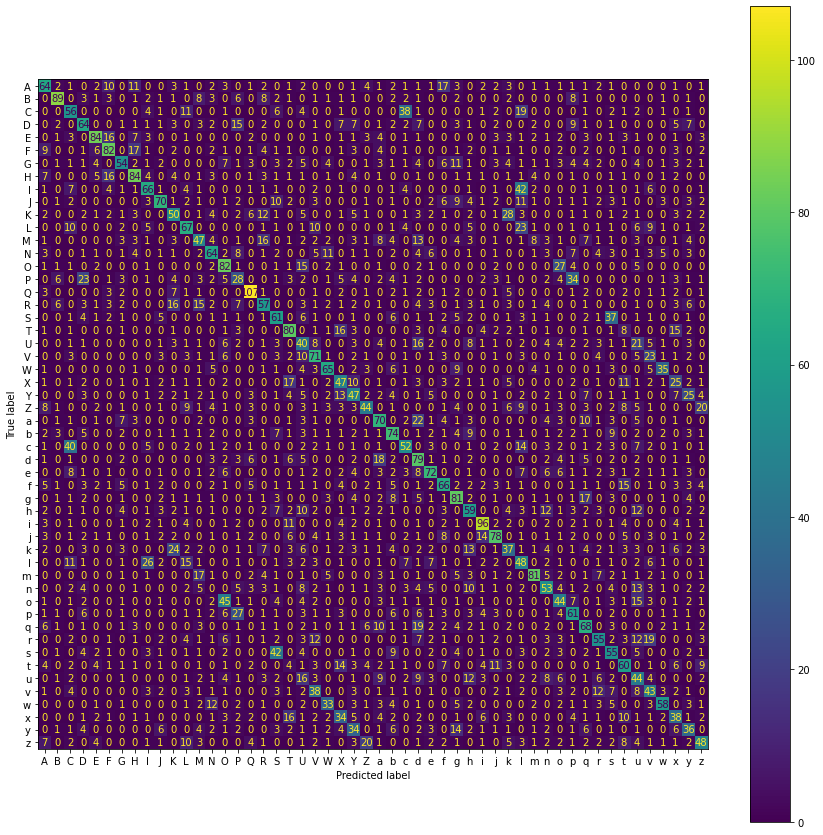

In [716]:
fig, ax = plt.subplots(figsize=(15,15))
ConfusionMatrixDisplay.from_predictions(y_test_resampled, test_pred, ax=ax)
plt.show()

### SVM

In [711]:
from sklearn.svm import LinearSVC

In [712]:
pipeline_svm = Pipeline([('scaler', StandardScaler()), 
                     ('model',LinearSVC(max_iter=10000))])

In [713]:
pipeline_svm.fit(X_train_mixed_features, y_train_resampled)

/home/abegaev/miniconda3/envs/stabillo-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LinearSVC(max_iter=10000))])

In [714]:
pipeline_svm.score(X_test_mixed_features, y_test_resampled)

0.4054801407742584

In [715]:
test_pred = pipeline_svm.predict(X_test_mixed_features)

### Bayesian

In [217]:
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import accuracy_score

In [218]:
import pymc3 as pm
import theano
import theano.tensor as T
floatX = theano.config.floatX

In [219]:
le = LabelEncoder()
y_train_resampled_t = le.fit_transform(y_train_resampled)

In [220]:
y_train_resampled_t.shape

(23316,)

In [221]:
print(np.unique(y_train_resampled_t).shape)

(52,)


In [222]:
scaled = StandardScaler()

In [358]:
X_scaled =  scaled.fit_transform(X_train_mixed_features)

In [359]:
X_scaled.shape

(23316, 1943)

In [416]:
X_t_scaled =  scaled.transform(X_test_mixed_features)

In [404]:
from sklearn.feature_selection import SelectFromModel

In [405]:
mmodel =SelectFromModel(pipeline_basic['model'],prefit=True)

In [419]:
X_tr_thresh = mmodel.transform(X_scaled)

In [420]:
X_t_thresh = mmodel.transform(X_t_scaled)

In [422]:
X_tr_thresh.shape, X_t_thresh.shape

((23316, 954), (7956, 954))

In [423]:
X_t_thresh = X_t_thresh[:, :128]

In [436]:
from sklearn.decomposition import PCA

In [437]:
pca = PCA(n_components=128)
X_tr_decomp = pca.fit_transform(X_tr_thresh)

In [441]:
X_t_decomp = pca.fit_transform(X_t_thresh)

In [438]:
X_tr_decomp.shape

(23316, 128)

$w_1 \sim N(0, 1);  
w_2 \sim N(0, 1); 
p(\hat{y}) \sim P(softmax(w_1x + w_2))$

In [439]:
def construct_nn(ann_input, ann_output):
    model = pm.Model()
    #n_hidden = 16
    init_1 = np.random.rand(X_tr_decomp.shape[1], 52).astype(floatX)
    init_2= np.random.rand(1).astype(floatX)
    init_3 = np.random.rand(256, 52).astype(floatX)
    with model:
      ann_input = pm.Data("ann_input", X_tr_decomp)
      ann_output = pm.Data("ann_output", y_train_resampled_t)
      weights_in_1 = pm.Normal("w",1, sigma=1, shape=(X_tr_decomp.shape[1], 52), testval=init_1)
      weights_b = pm.Normal("bias", 0, sigma=1, shape=(1, 52), testval=init_2)

      p = pm.math.dot(ann_input, weights_in_1) + weights_b

      #sigma = pm.HalfNormal('sigma', sd=1, shape=(X_train_concated.shape[0], 52))

      printing_op = theano.printing.Print('vector', attrs=['shape'])
      printed_x = printing_op(p)
      printed_x = printing_op(pm.math.exp(p))
      printed_x = printing_op(ann_output)
      #latent = pm.Normal('latent', mu=mu, sd=sigma, shape=X_train_concated.shape[0])


      p1 = pm.Deterministic('p', p.exp()/p.exp().sum())
      #probs = pm.math.exp(p) / pm.math.sum(pm.math.exp(p), 0, keepdims=True)

      printed_x = printing_op(p1)
      Y_obs = pm.Categorical('y_obs', p=p1, observed=ann_output)#, total_size=y_train_resampled_t.shape[0])
    
    return model


In [440]:
neural_network_minibatch = construct_nn(None, None)
with neural_network_minibatch:
  inference = pm.ADVI()
  approx = pm.fit(n=10000, method=inference)

vector shape = (23316, 52)
vector shape = (23316, 52)
vector shape = (23316,)
vector shape = (23316, 52)


Finished [100%]: Average Loss = 1.0727e+05


In [ ]:
X_test_scaled = scaled.transform(X_test_mixed_features)

In [443]:
# create symbolic input
x = T.matrix("X")
# symbolic number of samples is supported, we build vectorized posterior on the fly
n = T.iscalar("n")
# Do not forget test_values or set theano.config.compute_test_value = 'off'
x.tag.test_value = np.empty_like(X_tr_decomp[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(
    neural_network_minibatch.y_obs.distribution.p, size=n, more_replacements={neural_network_minibatch["ann_input"]: x}
)

sample_proba = theano.function([x, n], _sample_proba)

pred = sample_proba(X_t_decomp, 500).mean(0)



In [ ]:
np.argmax(pred, axis=-1).shape

In [444]:
y_test_resampled_t = le.fit_transform(y_test_resampled)
accuracy_score(y_test_resampled_t,np.argmax(pred, axis=-1))

0.043489190548014076

### XGBoost

In [575]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier

In [576]:
xgb_pipeline =Pipeline([('scaler', StandardScaler()), 
                     ('model', XGBClassifier(n_estimators=500,max_depth=10,learning_rate=0.1))])

In [577]:
xgb_pipeline.fit(X_train_mixed_feat4ures, y_train_resampled)

/home/abegaev/miniconda3/envs/stabillo-env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:37:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=500,
                               n_jobs=64, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=None, subsample=1,
                               tree_method='exact', validate_parameters=1,
    

In [578]:
xgb_pipeline.score(X_test_mixed_features, y_test_resampled)

0.5690045248868778

In [581]:
test_pred = xgb_pipeline.predict(X_test_mixed_features)

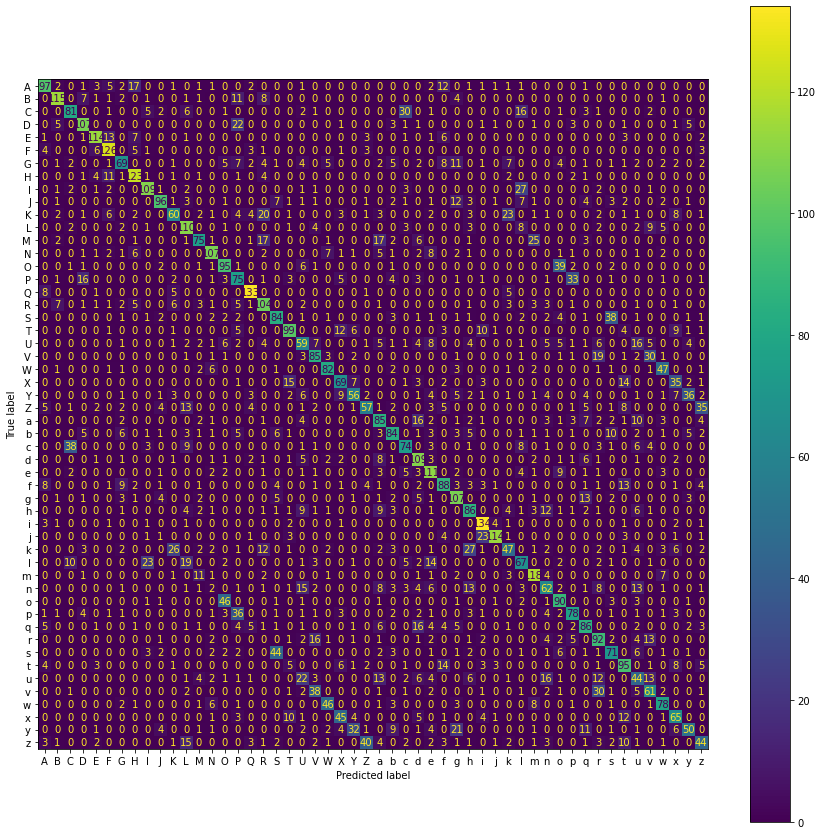

In [582]:
fig, ax = plt.subplots(figsize=(15,15))
ConfusionMatrixDisplay.from_predictions(y_test_resampled, test_pred, ax=ax)
plt.show()

### LightGBM

In [670]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from lightgbm import LGBMClassifier

In [681]:
lgbm_pipeline_mixed =Pipeline([('scaler', StandardScaler()), 
                     ('model', LGBMClassifier(n_estimators=500,max_depth=10,learning_rate=0.1))])

In [682]:
lgbm_pipeline_mixed.fit(X_train_mixed_features, y_train_resampled)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LGBMClassifier(max_depth=10, n_estimators=500))])

In [683]:
lgbm_pipeline_mixed.score(X_test_mixed_features, y_test_resampled)

0.5759175465057818

In [ ]:
0.5715183509301156


In [679]:
test_pred = lgbm_pipeline_mixed.predict(X_test_mixed_features)

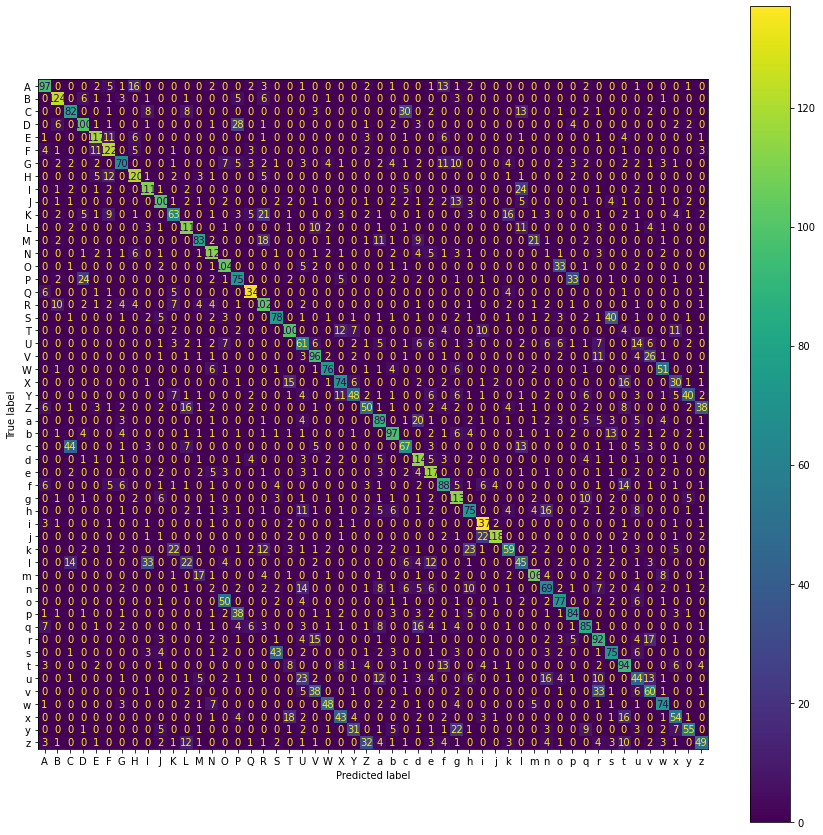

In [680]:
fig, ax = plt.subplots(figsize=(15,15))
ConfusionMatrixDisplay.from_predictions(y_test_resampled, test_pred, ax=ax)
plt.show()

## Model Small Case

In [633]:
feats_sm = get_acc_gyro_features(X_train_small_resampled, X_test_small_resampled)
acc_train_filt, acc_test_filt = filter_acc_features(feats_sm[0], feats_sm[1], y_train_small_resampled)
gyro_train_filt, gyro_test_filt = filter_gyro_features(feats_sm[2], feats_sm[3], y_train_small_resampled)
feat_magn_force_sm = get_magn_force_features(X_train_small_resampled, X_test_small_resampled, y_train_small_resampled)
X_train_small_features = np.concatenate([acc_train_filt, gyro_train_filt, feat_magn_force_sm[0], feat_magn_force_sm[2]], axis=-1)
X_test_small_features = np.concatenate([acc_test_filt, gyro_test_filt, feat_magn_force_sm[1], feat_magn_force_sm[3]], axis=-1)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


/home/abegaev/miniconda3/envs/stabillo-env/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
Feature Extraction: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:09<00:00, 16.69it/s]


### LogisticRegression

In [634]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [635]:
pipeline_lg_basic = Pipeline([('scaler', StandardScaler()), 
                     ('model',LogisticRegression(max_iter=10000))])
pipeline_lg_basic.fit(X_train_small_features, y_train_small_resampled)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(max_iter=10000))])

In [636]:
pipeline_lg_basic.score(X_test_small_features, y_test_small_resampled)

0.5975364504776269

In [637]:
test_pred = pipeline_lg_basic.predict(X_test_small_features)

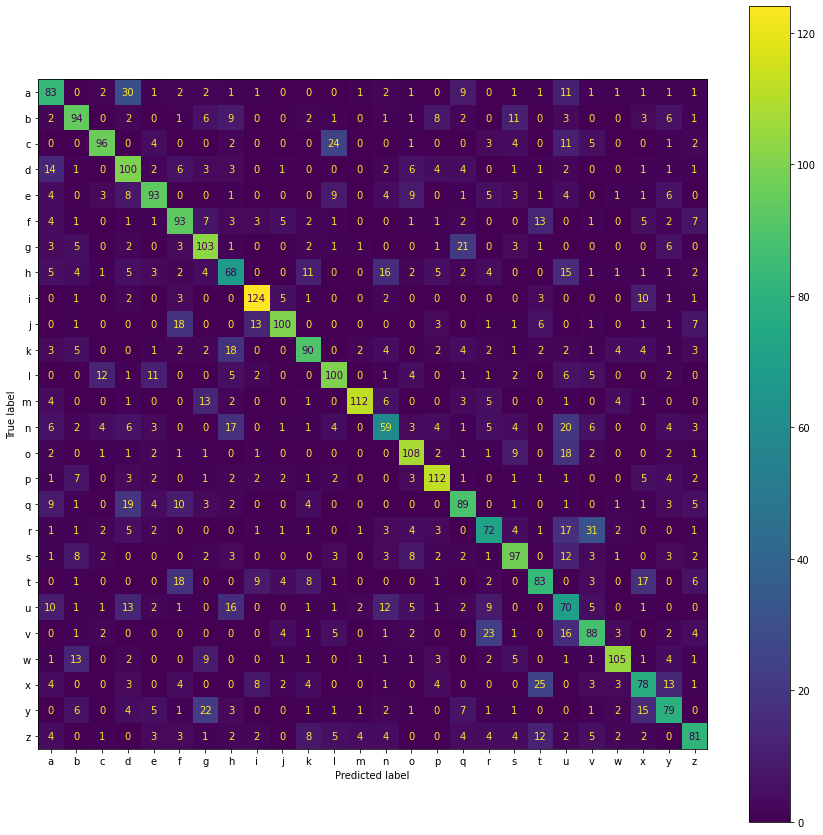

In [638]:
fig, ax = plt.subplots(figsize=(15,15))
ConfusionMatrixDisplay.from_predictions(y_test_small_resampled, test_pred, ax=ax)
plt.show()

### SVM

In [728]:
from sklearn.svm import LinearSVC

In [729]:
pipeline_svm = Pipeline([('scaler', StandardScaler()), 
                     ('model',LinearSVC(max_iter=10000))])

In [730]:
pipeline_svm.fit(X_train_small_features, y_train_small_resampled)

/home/abegaev/miniconda3/envs/stabillo-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LinearSVC(max_iter=10000))])

In [731]:
pipeline_svm.score(X_test_small_features, y_test_small_resampled)

0.5382101558572147

In [732]:
test_pred = pipeline_svm.predict(X_test_small_features)

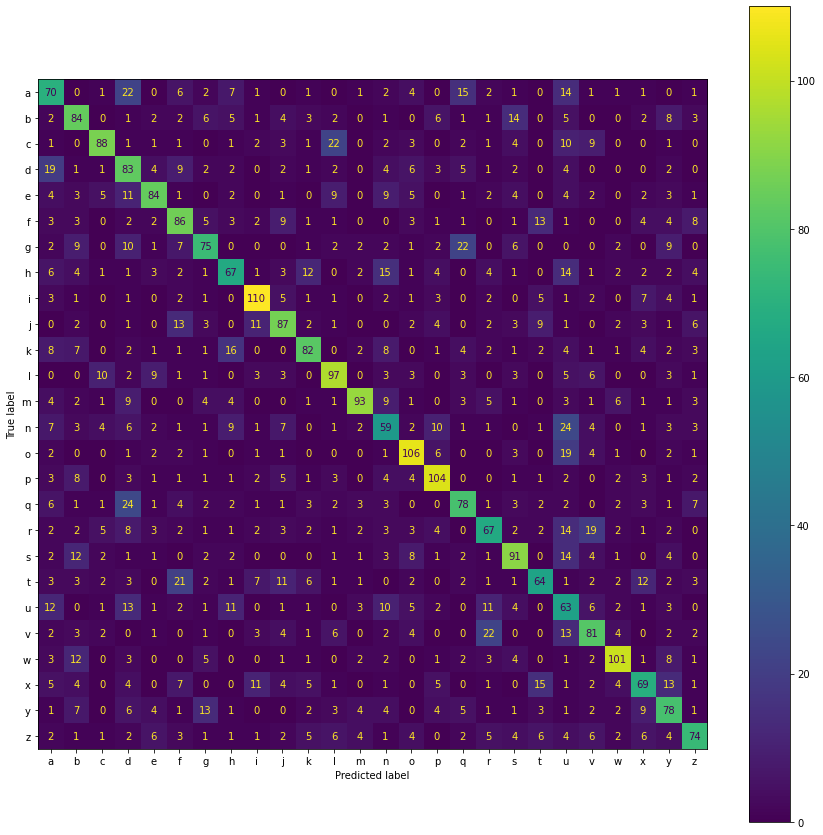

In [733]:
fig, ax = plt.subplots(figsize=(15,15))
ConfusionMatrixDisplay.from_predictions(y_test_small_resampled, test_pred, ax=ax)
plt.show()

### XGBoost

In [639]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier

In [640]:
xgb_sm_pipeline =Pipeline([('scaler', StandardScaler()), 
                        ('model', XGBClassifier(n_estimators=500,max_depth=10,learning_rate=0.1))])

In [641]:
xgb_sm_pipeline.fit(X_train_small_features, y_train_small_resampled)

/home/abegaev/miniconda3/envs/stabillo-env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:51:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=500,
                               n_jobs=64, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=None, subsample=1,
                               tree_method='exact', validate_parameters=1,
    

In [642]:
xgb_sm_pipeline.score(X_test_small_features, y_test_small_resampled)

0.6752136752136753

In [643]:
test_pred = xgb_sm_pipeline.predict(X_test_small_features)

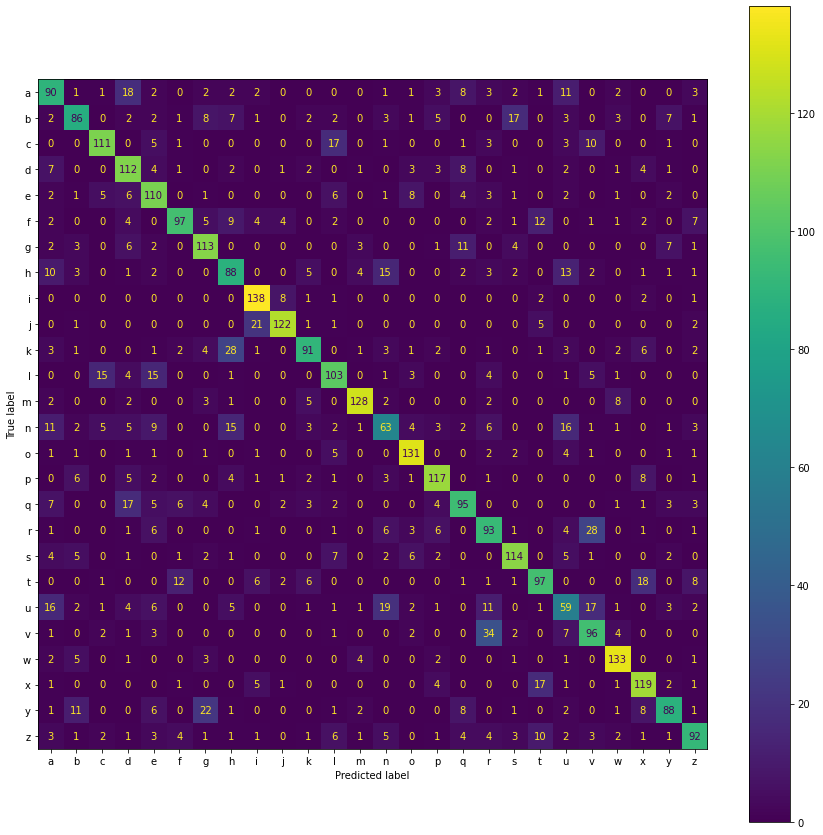

In [644]:
fig, ax = plt.subplots(figsize=(15,15))
ConfusionMatrixDisplay.from_predictions(y_test_small_resampled, test_pred, ax=ax)
plt.show()

### LightGBM

In [670]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from lightgbm import LGBMClassifier

In [684]:
lgbm_pipeline_small =Pipeline([('scaler', StandardScaler()), 
                     ('model', LGBMClassifier(n_estimators=500,max_depth=10,learning_rate=0.1))])

In [685]:
lgbm_pipeline_small.fit(X_train_small_features, y_train_small_resampled)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LGBMClassifier(max_depth=10, n_estimators=500))])

In [687]:
lgbm_pipeline_small.score(X_test_small_features, y_test_small_resampled)

0.6993464052287581

In [688]:
test_pred = lgbm_pipeline_small.predict(X_test_small_features)

## Model Large Case

In [645]:
feats_lg = get_acc_gyro_features(X_train_large_resampled, X_test_large_resampled)
acc_train_filt, acc_test_filt = filter_acc_features(feats_lg[0], feats_lg[1], y_train_large_resampled)
gyro_train_filt, gyro_test_filt = filter_gyro_features(feats_lg[2], feats_lg[3], y_train_large_resampled)
feat_magn_force_lg = get_magn_force_features(X_train_large_resampled, X_test_large_resampled, y_train_large_resampled)
X_train_large_features = np.concatenate([acc_train_filt, gyro_train_filt, feat_magn_force_lg[0], feat_magn_force_lg[2]], axis=-1)
X_test_large_features = np.concatenate([acc_test_filt, gyro_test_filt, feat_magn_force_lg[1], feat_magn_force_lg[3]], axis=-1)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


/home/abegaev/miniconda3/envs/stabillo-env/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
Feature Extraction: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:09<00:00, 17.11it/s]


### LogisticRegression

In [646]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [647]:
pipeline_lg_basic = Pipeline([('scaler', StandardScaler()), 
                     ('model',LogisticRegression(max_iter=10000))])
pipeline_lg_basic.fit(X_train_large_features, y_train_large_resampled)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(max_iter=10000))])

In [649]:
pipeline_lg_basic.score(X_test_large_features, y_test_large_resampled)

0.6699346405228758

In [650]:
test_pred = pipeline_lg_basic.predict(X_test_large_features)

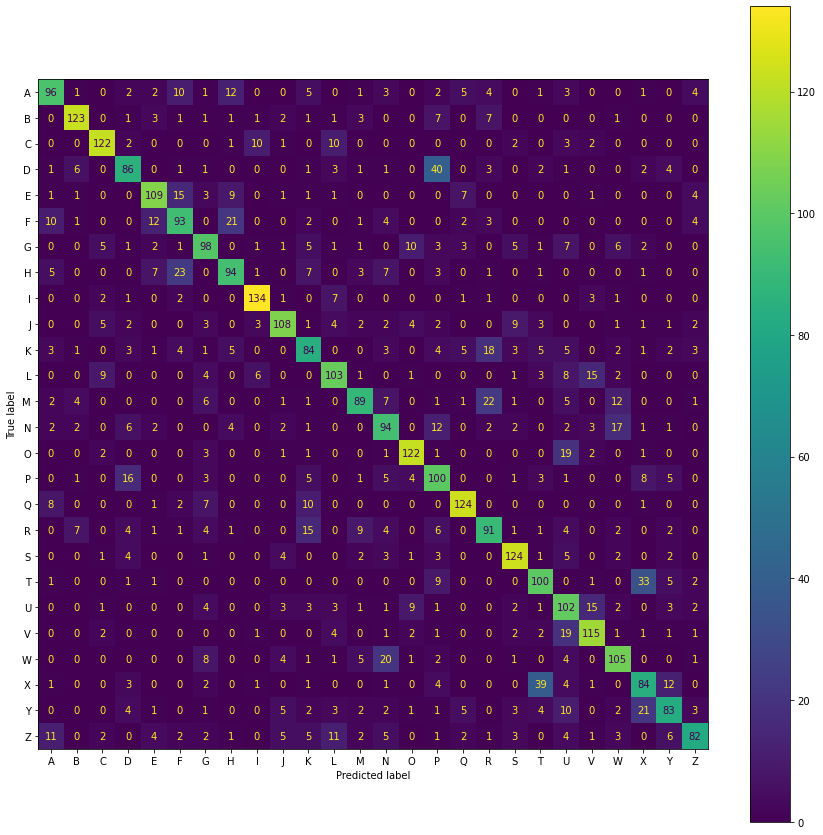

In [651]:
fig, ax = plt.subplots(figsize=(15,15))
ConfusionMatrixDisplay.from_predictions(y_test_large_resampled, test_pred, ax=ax)
plt.show()

### SVM

In [728]:
from sklearn.svm import LinearSVC

In [758]:
pipeline_svm = Pipeline([('scaler', StandardScaler()), 
                     ('model',LinearSVC(max_iter=10000))])

In [759]:
pipeline_svm.fit(X_train_large_features, y_train_large_resampled)

/home/abegaev/miniconda3/envs/stabillo-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LinearSVC(max_iter=10000))])

In [760]:
pipeline_svm.score(X_test_large_features, y_test_large_resampled)

0.6033182503770739

In [761]:
test_pred = pipeline_svm.predict(X_test_large_features)

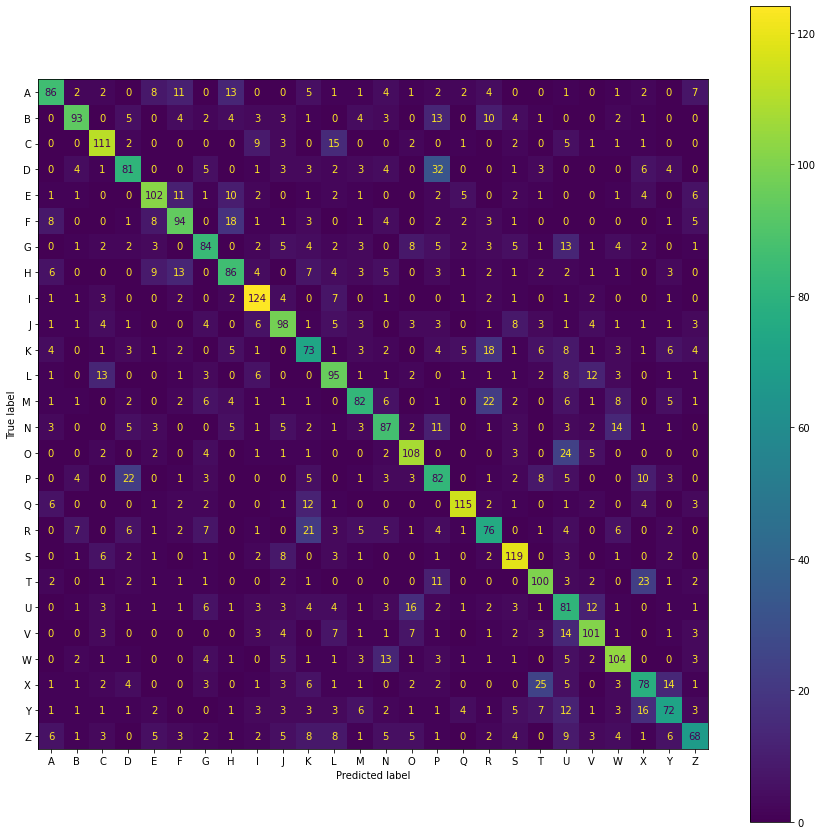

In [762]:
fig, ax = plt.subplots(figsize=(15,15))
ConfusionMatrixDisplay.from_predictions(y_test_large_resampled, test_pred, ax=ax)
plt.show()

### XGBoost

In [652]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier

In [658]:
xgb_lg_pipeline =Pipeline([#('scaler', StandardScaler()), 
                        ('model', XGBClassifier(n_estimators=500,max_depth=10,learning_rate=0.1))])

In [659]:
xgb_lg_pipeline.fit(X_train_large_features, y_train_large_resampled)

/home/abegaev/miniconda3/envs/stabillo-env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:47:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=500,
                               n_jobs=64, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=None, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [660]:
xgb_lg_pipeline.score(X_test_large_features, y_test_large_resampled)

0.7546505781799899

In [661]:
test_pred = xgb_lg_pipeline.predict(X_test_large_features)

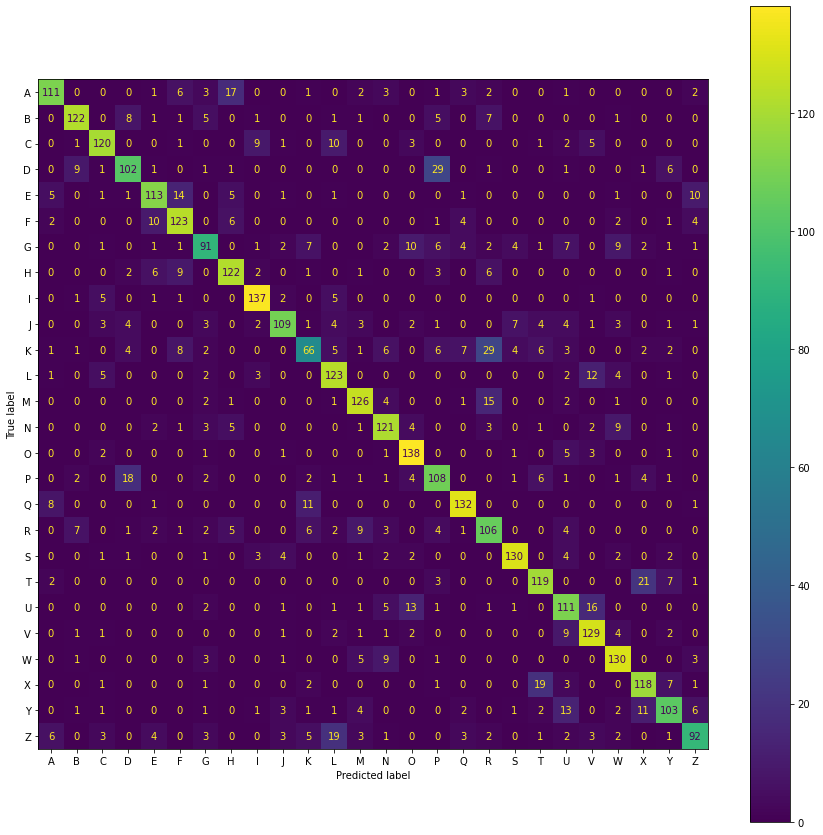

In [662]:
fig, ax = plt.subplots(figsize=(15,15))
ConfusionMatrixDisplay.from_predictions(y_test_large_resampled, test_pred, ax=ax)
plt.show()

### LightGBM

In [764]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from lightgbm import LGBMClassifier

In [765]:
lgbm_pipeline_large =Pipeline([('scaler', StandardScaler()), 
                     ('model', LGBMClassifier(n_estimators=500,max_depth=10,learning_rate=0.1))])

In [766]:
lgbm_pipeline_large.fit(X_train_large_features, y_train_large_resampled)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LGBMClassifier(max_depth=10, n_estimators=500))])

In [767]:
lgbm_pipeline_large.score(X_test_large_features, y_test_large_resampled)

0.7717445952740071

In [768]:
test_pred = lgbm_pipeline_large.predict(X_test_large_features)